In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
import pandas as pd
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [2]:

train_path = '/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_train/'
test_path = '/kaggle/input/aslamerican-sign-language-aplhabet-dataset/ASL_Alphabet_Dataset/asl_alphabet_test/'


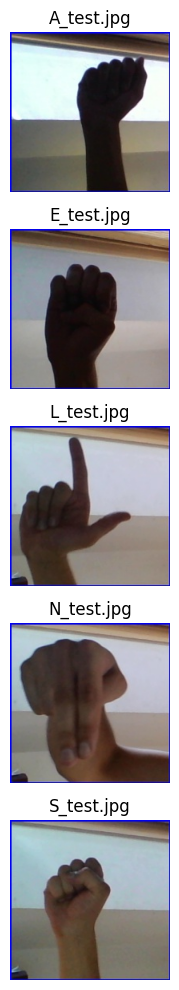

In [3]:
# Get a list of image files in the test folder
image_files = [f for f in os.listdir(test_path) if f.endswith('.jpg') or f.endswith('.png')]

# Select a few images to display
num_images_to_display = 5
images_to_display = image_files[:num_images_to_display]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=num_images_to_display, ncols=1, figsize=(5, 10))

# Display each image
for i, image_file in enumerate(images_to_display):
    image_path = os.path.join(test_path, image_file)
    img = plt.imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')  # Turn off axis labels
    axs[i].set_title(image_file)

# Show the plot
plt.tight_layout()
plt.show()

In [4]:
# Function to load images and labels
def load_data(folder_path, img_size=(64, 64)):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_filename in os.listdir(label_path):
                img_path = os.path.join(label_path, img_filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(label)
    return images, labels

In [5]:
classes = os.listdir(train_path)
print(classes)
filepaths = []
labels = []
for d in classes:
    flist = os.listdir(os.path.join(train_path, d))
    for f in flist:
        fpath = os.path.join(train_path, d, f)
        filepaths.append(fpath)
        labels.append(d)

print('Filepaths: ', len(filepaths), '   Labels: ', len(labels))

['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'nothing', 'J']
Filepaths:  223074    Labels:  223074


In [6]:
import collections

label_counts = collections.Counter(labels)
min_label = min(label_counts, key=label_counts.get)
min_count = label_counts[min_label]

print(f"Category with minimum number of images: {min_label} ({min_count} images)")

Category with minimum number of images: nothing (3030 images)


In [7]:
# Create a DataFrame for balancing the dataset
df = pd.DataFrame({'file_paths': filepaths, 'labels': labels})
file_count = 500  # Adjust as needed to ensure the total dataset size is around 20,000

samples = []
for category in df['labels'].unique():
    category_slice = df.query("labels == @category")
    samples.append(category_slice.sample(file_count, replace=False, random_state=1))

balanced_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(balanced_df['labels'].value_counts())
print(len(balanced_df))

filepaths = balanced_df['file_paths'].tolist()
labels = balanced_df['labels'].tolist()


labels
L          500
X          500
D          500
P          500
N          500
Q          500
T          500
B          500
O          500
C          500
H          500
I          500
space      500
J          500
U          500
S          500
E          500
Z          500
G          500
R          500
V          500
K          500
del        500
M          500
F          500
Y          500
W          500
A          500
nothing    500
Name: count, dtype: int64
14500


In [8]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


In [9]:
filepaths_train, filepaths_test, labels_train, labels_test = train_test_split(filepaths, encoded_labels, test_size=0.2, random_state=42)


In [10]:
def extract_hog_features(filepaths, img_size=(64, 64)):
    features = []
    for filepath in filepaths:
        img = cv2.imread(filepath)
        if img is not None:
            img = cv2.resize(img, img_size)
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            feature = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            features.append(feature)
    return np.array(features)

X_train = extract_hog_features(filepaths_train)
X_test = extract_hog_features(filepaths_test)


In [11]:
# Train and evaluate SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, labels_train)
svm_accuracy = accuracy_score(labels_test, svm_model.predict(X_test))
print(f'SVM Test accuracy: {svm_accuracy:.4f}')

# Train and evaluate KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, labels_train)
knn_accuracy = accuracy_score(labels_test, knn_model.predict(X_test))
print(f'KNN Test accuracy: {knn_accuracy:.4f}')

# Train and evaluate Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, labels_train)
rf_accuracy = accuracy_score(labels_test, rf_model.predict(X_test))
print(f'Random Forest Test accuracy: {rf_accuracy:.4f}')


SVM Test accuracy: 0.7890
KNN Test accuracy: 0.7807
Random Forest Test accuracy: 0.7897


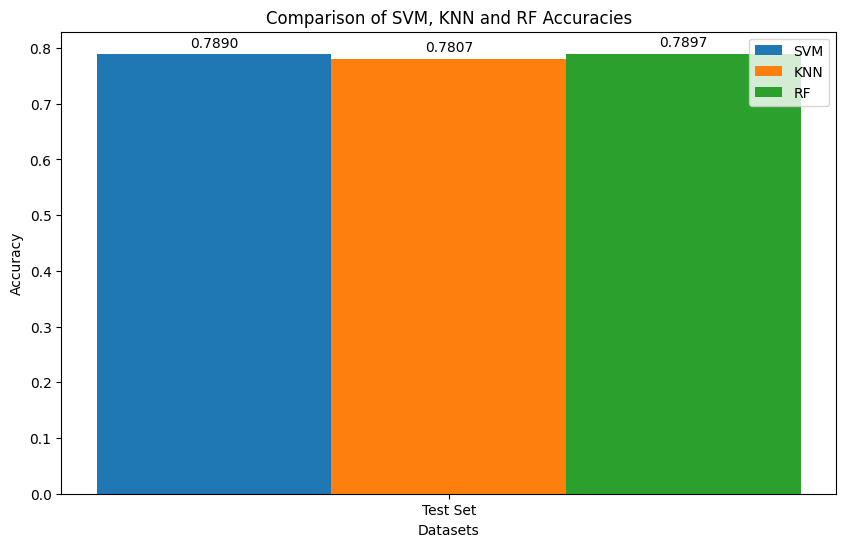

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracies for both models on both datasets
models = ['SVM', 'KNN', 'Random Forest']
datasets = ['Test Set']
accuracies = {
    'SVM': [svm_accuracy],
    'KNN': [knn_accuracy],
    'RF': [rf_accuracy]
}

# Creating the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(datasets))

svm_bar = ax.bar(index, accuracies['SVM'], bar_width, label='SVM')
knn_bar = ax.bar(index + bar_width, accuracies['KNN'], bar_width, label='KNN')
rf_bar = ax.bar(index + 2*bar_width, accuracies['RF'], bar_width, label='RF')  # Corrected 'rf' to 'RF' and index + bar_width to index + 2*bar_width


# Adding the labels, title, and legend
ax.set_xlabel('Datasets')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of SVM, KNN and RF Accuracies')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(datasets)
ax.legend()

# Adding the accuracy values on top of the bars
for rect in svm_bar.patches + knn_bar.patches + rf_bar.patches:  # Corrected svm_bar + knn_bar to svm_bar.patches + knn_bar.patches + rf_bar.patches
    height = rect.get_height()
    ax.annotate(f'{height:.4f}', 
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')

plt.show()

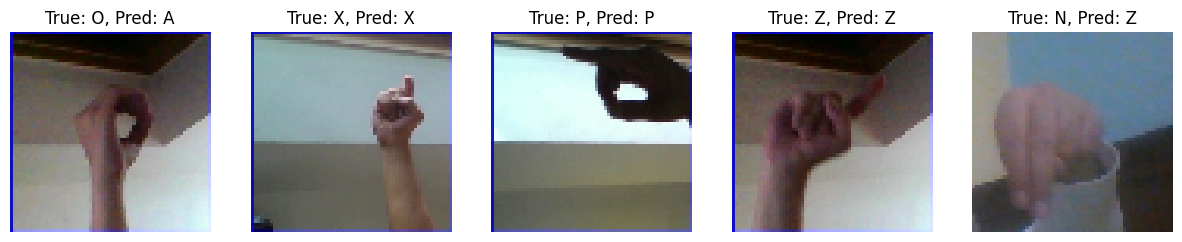

In [13]:
def display_predictions(model, filepaths, features, labels, num_samples=5, img_size=(64, 64)):
    random_indices = random.sample(range(len(filepaths)), num_samples)
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(random_indices):
        img = cv2.imread(filepaths[idx])
        if img is not None:
            img = cv2.resize(img, img_size)
            pred = model.predict([features[idx]])[0]
            pred_label = label_encoder.inverse_transform([pred])[0]

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"True: {label_encoder.inverse_transform([labels[idx]])[0]}, Pred: {pred_label}")
            plt.axis('off')
    plt.show()

display_predictions(rf_model, filepaths_test, X_test, labels_test, num_samples=5)
 